### Imports

In [1]:
import os
from collections import Counter
from itertools import cycle

os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"


import lightning.pytorch as pl
import missingno as msno
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn.functional as F
import torch.optim.lr_scheduler
import wandb
from imblearn.over_sampling import SMOTE
from lightning.pytorch.callbacks import Callback, LearningRateMonitor
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from lightning.pytorch.loggers import WandbLogger
from pandas import DataFrame
from sklearn.calibration import label_binarize
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    accuracy_score,
    classification_report,
    confusion_matrix,
    precision_recall_curve,
)
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from torch import nn, utils
from torch.utils.data import DataLoader, Dataset

print(torch.__version__)
print(pl.__version__)
device_string = (
    "mps"
    if torch.backends.mps.is_built()
    else "cuda:0"
    if torch.cuda.is_available()
    else "cpu"
)
print(f"MPS Available : {torch.backends.mps.is_built()}")
print(f"CUDA availabe : {torch.cuda.is_available()}")
DEVICE = torch.device(device_string)
print(f"GPU - {DEVICE}")


2.0.1
2.0.2
MPS Available : True
CUDA availabe : False
GPU - mps


# Data Preparation

(1616, 293)
291


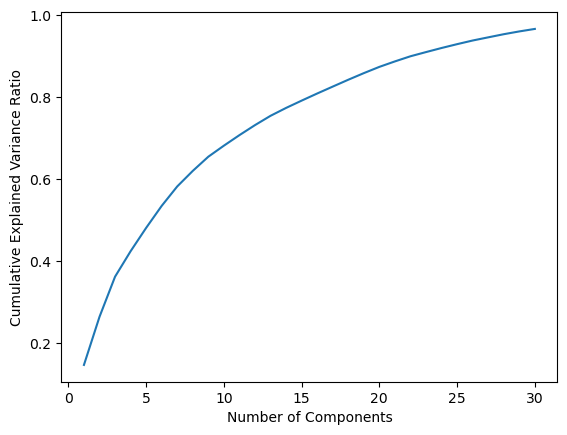

#>============================================================<#
	Dropping class: 34	 As there is only 4 instance
#>============================================================<#
At class 31: 32 examples 	which is Miscellaneous 
#>============================================================<#
	Dropping class: 30	 As there is only 2 instance
#>============================================================<#
At class 29: 28 examples 	which is Alcoholic beverages 
At class 28: 33 examples 	which is Confectionery and cereal/nut/fruit/seed bars 
#>============================================================<#
	Dropping class: 27	 As there is only 19 instance
#>============================================================<#
#>============================================================<#
	Dropping class: 26	 As there is only 11 instance
#>============================================================<#
At class 24: 235 examples 	which is Vegetable products and dishes 
At class 23: 37 examples 	wh

In [8]:
df: DataFrame = pd.read_excel(
    io="./Datasets/Rel_2_Nutrient_file.xlsx",
    sheet_name="All solids &amp; liquids per 100g",
)
print(df.shape)
print(len(df.Classification.copy().astype(str).unique()))
df["Classification"] = df["Classification"].astype(str)
df["Classification"] = pd.to_numeric(
    df["Classification"].str.extract(r"(\d{2})")[0], errors="coerce"
)

new_df: DataFrame = (
    df.filter(regex="^(?!.*\(%T\)).*")
    .drop(
        labels=[
            "Public Food Key",
            "Food Name",
        ],
        axis=1,
    )
    .dropna(thresh=(int(len(df) * 0.95)), axis="columns")
    .dropna()
)

classifications_df: DataFrame = pd.read_excel(
    io="./Datasets/Australian_Health_Survey_Classification_System.xlsx"
)
classifications_df = classifications_df[
    (classifications_df["Food Group Code"] // 100).between(0, 1)
]

classifications = pd.Series(
    classifications_df["Food Group and Sub-Group Name"],
    index=classifications_df["Food Group Code"].values,
).to_dict()

classifications = dict(
    zip(
        classifications_df["Food Group Code"],
        classifications_df["Food Group and Sub-Group Name"],
    )
)

use_pca: bool = True

features = new_df.drop(
    "Classification", axis=1
).copy()  # Drop the target column to get the features
target = new_df["Classification"].copy()  # Save the target column separately

if use_pca:
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(features)

    pca = PCA(n_components=30)  # Choose the desired number of components
    pca_result = pca.fit_transform(scaled_features)

    pca_df = pd.DataFrame(
        data=pca_result,
        columns=[
            "PC1",
            "PC2",
            "PC3",
            "PC4",
            "PC5",
            "PC6",
            "PC7",
            "PC8",
            "PC9",
            "PC10",
            "PC11",
            "PC12",
            "PC13",
            "PC14",
            "PC15",
            "PC16",
            "PC17",
            "PC18",
            "PC19",
            "PC20",
            "PC21",
            "PC22",
            "PC23",
            "PC24",
            "PC25",
            "PC26",
            "PC27",
            "PC28",
            "PC29",
            "PC30",
            # "PC31",
            # "PC32",
            # "PC33",
            # "PC34",
            # "PC35",
            # "PC36",
            # "PC37",
            # "PC38",
            # "PC39",
            # "PC40",
            # "PC41",
            # "PC42",
            # "PC43",
            # "PC44",
            # "PC45",
            # "PC46",
            # "PC47",
            # "PC48",
            # "PC49",
            # "PC50",
            # "PC51",
            # "PC52",
            # "PC53",
            # "PC54",
            # "PC55",
            # "PC56",
            # "PC57",
            # "PC58",
            # "PC59",
            # "PC60",
        ],
    )  # Adjust column names as needed

    final_df = pd.concat([pca_df, target], axis=1)

    cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

    import matplotlib.pyplot as plt

    plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance)
    plt.xlabel("Number of Components")
    plt.ylabel("Cumulative Explained Variance Ratio")
    plt.show()

    new_df = final_df.copy()
else:
    final_df = pd.concat([features, target], axis=1)

    new_df = final_df.copy()


class_list = new_df.Classification.tolist()

class_counts = Counter(new_df["Classification"].copy())
for element, count in class_counts.items():
    if count <= 20:
        new_df = new_df.drop(new_df[new_df["Classification"] == element].index)
        print("#>============================================================<#")
        print(f"\tDropping class: {element}\t As there is only {count} instance")
        print("#>============================================================<#")
    else:
        print(
            f"At class {element}: {count} examples \twhich is {classifications.get(element)}"
        )

print(class_counts)

n_classes: int = len(pd.unique(new_df.Classification))

print(f"Num classes: {n_classes}")
print(Counter(new_df["Classification"].copy()))

# Create a new column to store the sequential numbers
new_df["Classification_seq"], classifications_seq = pd.factorize(
    new_df["Classification"]
)

# Get unique classifications and their corresponding sequential numbers
# classifications_unique = np.unique(new_df["Classification"])
# classifications_seq_unique = np.unique(new_df["Classification_seq"])

# Create a dictionary to map the original class to a string representation
class_dict = dict(zip(new_df["Classification_seq"], new_df["Classification"]))
mapped_dict = {
    key: classifications.get(intermediate_value)
    for key, intermediate_value in class_dict.items()
}

# Display the class dictionary
print(f"class_seq -> class: {class_dict}")
print(f"class -> class name: {classifications}")
print(f"class_seq -> class name: {mapped_dict}")


print(f"Dataframe head: {new_df.head()}")


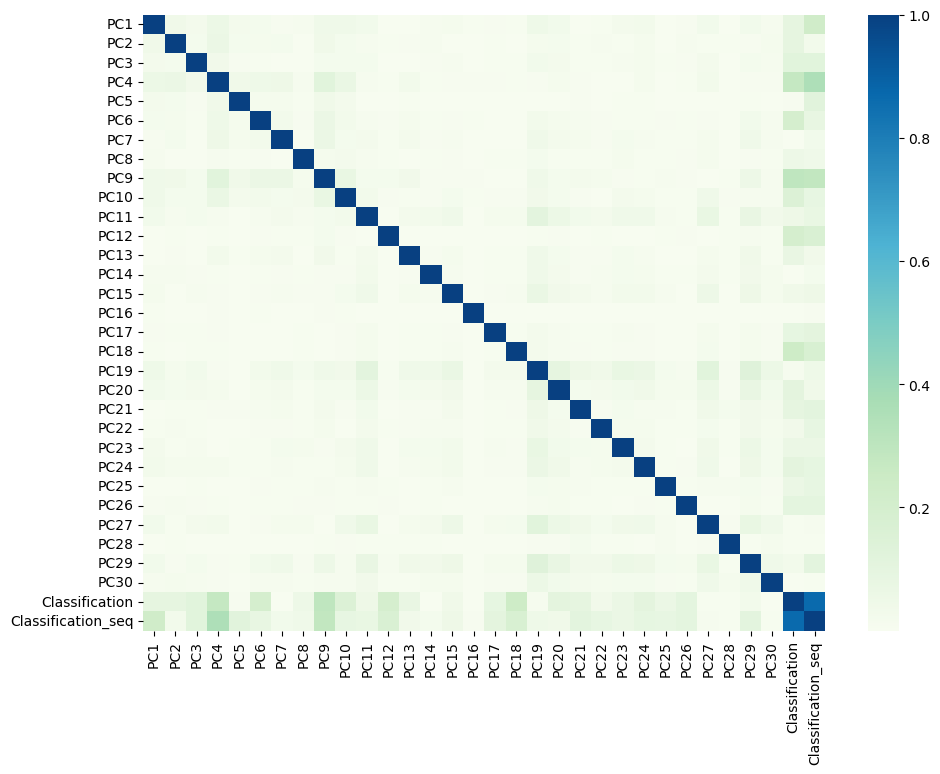

In [3]:
corr = new_df.corr(min_periods=0).abs()
plt.figure(figsize=(11, 8))
sns.heatmap(corr, cmap="GnBu", annot=False)
plt.show()


new_df.Classification = new_df.Classification.map(classifications)


In [4]:
smote_all: bool = True
smote = SMOTE(random_state=42, k_neighbors=5)
# print(new_df.Classification)
train, test = train_test_split(
    new_df,
    test_size=0.3,
    random_state=42,
    shuffle=True,
    stratify=new_df.Classification,
)

X_train = train.drop(columns=["Classification", "Classification_seq"])
y_train = train["Classification"]
X_train, y_train = smote.fit_resample(X_train, y_train)
X_test = test.drop(columns=["Classification", "Classification_seq"])
y_test = test["Classification"]

if smote_all:
    # Split the original dataset into features and labels
    X = new_df.drop(columns=["Classification", "Classification_seq"])
    y = new_df["Classification_seq"]

    # Apply SMOTE to the entire dataset
    X_resampled, y_resampled = smote.fit_resample(X, y)

    # Split the resampled dataset into train and test sets
    MLP_X_train, MLP_X_test, MLP_y_train, MLP_y_test = train_test_split(
        X_resampled,
        y_resampled,
        test_size=0.4,
        random_state=42,
        shuffle=True,
        stratify=y_resampled,
    )
else:
    MLP_X_train = X_train
    MLP_y_train = train["Classification_seq"]

    MLP_X_test = X_test
    MLP_y_test = test["Classification_seq"]


# Print the shapes of the train and test sets
print("Train set shapes:", MLP_X_train.shape, MLP_y_train.shape)
print("Test set shapes:", MLP_X_test.shape, MLP_y_test.shape)

print(MLP_X_train.head())
print("==================================================")
print(MLP_y_train)


Train set shapes: (4464, 30) (4464,)
Test set shapes: (2976, 30) (2976,)
           PC1       PC2       PC3       PC4       PC5       PC6       PC7   
2957 -2.312606 -1.603936  0.750871  1.980152  0.532394 -1.396541 -0.066129  \
632   3.150526 -1.972758 -1.063796 -0.574820 -2.025170  1.233069  0.728715   
3894 -2.394263 -0.257627 -1.003599  1.189735  0.144265  0.725056 -0.306675   
7312  1.500587 -2.308453 -0.634933 -0.500121 -0.507739 -0.099513  0.171052   
6892  2.374641  2.018408  3.051504 -0.848012 -1.017199 -3.979634  0.299066   

           PC8       PC9      PC10  ...      PC21      PC22      PC23   
2957 -0.426628  0.568623  0.079142  ... -0.416671  0.091941  0.214725  \
632   0.024092  1.226224  0.363437  ...  0.866559 -0.326311 -0.255208   
3894  0.094043 -0.438096  0.259166  ...  0.033716  0.534701 -0.345467   
7312  0.067415  0.199326 -0.431499  ... -0.695150  0.199795  0.011983   
6892 -1.413774 -1.026016  0.284059  ...  3.811291  0.217172  2.386864   

          PC24     

In [5]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

MLP_scaler = StandardScaler()
MLP_X_train = scaler.fit_transform(MLP_X_train)
MLP_X_test = scaler.transform(MLP_X_test)


# KNN classifier

In [ ]:
steps = 5
best_acc = -1
best_k = -1
best_loss = -1
best_y_pred = -1
best_y_proba = -1
best_model = None


for i in range(steps):
    # Create the k-NN classifier with k=3
    k = 2 ** (i + 1)
    knn = KNeighborsClassifier(n_neighbors=k)

    # Fit the classifier to the training data
    knn.fit(X_train, y_train)
    # Make predictions on the training set and calculate the training loss
    y_train_pred = knn.predict(X_train)
    train_acc = accuracy_score(y_train, y_train_pred)
    train_loss = 1 - train_acc

    # Make predictions on the test set and calculate the test loss
    y_test_pred = knn.predict(X_test)
    y_test_pred_proba = knn.predict_proba(X_test)
    test_acc = accuracy_score(y_test, y_test_pred)
    test_loss = 1 - test_acc

    print(
        f">===========================\t{k} nearest neighbours\t===========================<"
    )
    print(f"Training loss:\t{train_loss:.4f}\tTraining accuracy:\t{train_acc:.4f}")
    print(f"Test loss:\t{test_loss:.4f}\tTest accuracy:\t\t{test_acc:.4f}")

    if test_acc > best_acc:
        best_acc = test_acc
        best_k = k
        best_loss = test_loss
        best_y_pred = y_test_pred
        best_y_proba = y_test_pred_proba
        best_model = knn

print(f"\nBest model found with {best_k} Nearest neighbours\n")
knn_report = classification_report(y_test, best_y_pred)
knn_df_report = pd.DataFrame(
    classification_report(y_test, best_y_pred, output_dict=True)
)
report = classification_report(y_test, best_y_pred)

print(report)

cm = confusion_matrix(best_y_pred, y_test, labels=best_model.classes_)

fig, ax = plt.subplots()
ax.set_title(f"Best accuracy of {best_acc:.4f} found with a depth of {best_k}")

disp: ConfusionMatrixDisplay = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=best_model.classes_,
).plot(xticks_rotation="vertical", ax=ax)


In [ ]:
# Binarize the true labels
binarized_labels = label_binarize(y_test, classes=list(set(y_test)))

# Calculate precision and recall for each class
precision = dict()
recall = dict()
n_classes = len(set(y_test))
for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(
        binarized_labels[:, i], [proba[i] for proba in best_y_proba]
    )

# Define the number of subplots and the subplot layout
n_subplots = 3
n_rows = (n_classes + n_subplots - 1) // n_subplots
n_cols = min(n_subplots, n_classes)

# Create subplots for precision-recall curves
fig, axs = plt.subplots(n_rows, n_cols, figsize=(15, 40))
axs = axs.flatten()

# Plot the precision-recall curves for each class
colors = cycle(["navy", "turquoise", "darkorange", "green"])
line_styles = cycle(["-", "--"])
for i, ax in zip(range(n_classes), axs):
    color = next(colors)
    linestyle = next(line_styles)
    ax.plot(recall[i], precision[i], color=color, linestyle=linestyle, lw=2)
    ax.set_xlabel("Recall")
    ax.set_ylabel("Precision")
    ax.set_title(f"{best_model.classes_[i]}")

# Remove empty subplots if needed
if n_classes < len(axs):
    for j in range(n_classes, len(axs)):
        fig.delaxes(axs[j])

# Adjust the spacing between subplots
fig.tight_layout()

plt.show()


# Random Forest Classifier

In [ ]:
steps: int = 5
best_acc: int = -1
acc_diff: int = -1
best_depth: int = -1
best_cm = None
best_model = None

for i in range(steps):
    depth = 2 ** (i + 1)
    clf = RandomForestClassifier(max_depth=depth, random_state=42)
    clf.fit(X_train, y_train)

    y_train_pred = clf.predict(X_train)
    train_acc = accuracy_score(y_train, y_train_pred)
    train_loss = 1 - train_acc

    # Make predictions on the test set and calculate the test loss
    y_test_pred = clf.predict(X_test)
    test_acc = accuracy_score(y_test, y_test_pred)
    test_loss = 1 - test_acc

    print(
        f">===========================\tdepth of {depth}\t===========================<"
    )
    print(f"Training loss:\t{train_loss:.4f}\tTraining accuracy:\t{train_acc:.4f}")
    print(f"Test loss:\t{test_loss:.4f}\tTest accuracy:\t\t{test_acc:.4f}")

    if test_acc > best_acc:
        best_acc = test_acc
        best_depth = depth
        best_model = clf
        best_predict = y_test_pred
        best_predict_proba = clf.predict_proba(X_test)
        # Plot the decision regions and training/test data points
        best_cm = confusion_matrix(y_test_pred, y_test, labels=clf.classes_)

fig, ax = plt.subplots()
ax.set_title(f"\nBest accuracy of {best_acc:.4f} found with a depth of {best_depth}\n")

disp: ConfusionMatrixDisplay = ConfusionMatrixDisplay(
    confusion_matrix=best_cm,
    display_labels=clf.classes_,
).plot(xticks_rotation="vertical", ax=ax)

report = classification_report(y_test, y_test_pred)
df_report = pd.DataFrame(classification_report(y_test, y_test_pred, output_dict=True))

print(f"Best accuracy of {best_acc:.4f} found with a depth of {best_depth}")
print(report)


In [ ]:
# Binarize the true labels
binarized_labels = label_binarize(y_test, classes=list(set(y_test)))

# Calculate precision and recall for each class
precision = dict()
recall = dict()
n_classes = len(set(y_test))
for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(
        binarized_labels[:, i], [proba[i] for proba in best_predict_proba]
    )

# Define the number of subplots and the subplot layout
n_subplots = 3
n_rows = (n_classes + n_subplots - 1) // n_subplots
n_cols = min(n_subplots, n_classes)

# Create subplots for precision-recall curves
fig, axs = plt.subplots(n_rows, n_cols, figsize=(15, 40))
axs = axs.flatten()

# Plot the precision-recall curves for each class
colors = cycle(["navy", "turquoise", "darkorange", "green"])
line_styles = cycle(["-", "--"])
for i, ax in zip(range(n_classes), axs):
    color = next(colors)
    linestyle = next(line_styles)
    ax.plot(recall[i], precision[i], color=color, linestyle=linestyle, lw=2)
    ax.set_xlabel("Recall")
    ax.set_ylabel("Precision")
    ax.set_title(f"{best_model.classes_[i]}")

# Remove empty subplots if needed
if n_classes < len(axs):
    for j in range(n_classes, len(axs)):
        fig.delaxes(axs[j])

# Adjust the spacing between subplots
fig.tight_layout()

plt.show()


# CNN

In [6]:
class myTrainDataSet(Dataset):
    def __init__(self, x_train_df: DataFrame, y_train_df):
        self.X_train = torch.tensor(x_train_df, dtype=torch.float32)
        self.y_train = torch.tensor(y_train_df.values, dtype=torch.long)

    def __len__(self) -> int:
        return len(self.y_train)

    def __getitem__(self, idx):
        return self.X_train[idx], self.y_train[idx]


class myTestDataSet(Dataset):
    def __init__(self, x_test_df: DataFrame, y_test_df: DataFrame):
        self.X_test = torch.tensor(x_test_df, dtype=torch.float32)
        self.y_test = torch.tensor(y_test_df.values, dtype=torch.long)

    def __len__(self) -> int:
        return len(self.y_test)

    def __getitem__(self, idx):
        return self.X_test[idx], self.y_test[idx]


In [7]:
class CNNClassifier(pl.LightningModule):
    def __init__(
        self,
        input_size,
        hidden_size,
        num_classes,
        lr,
        dropout_rate=0.5,
    ):
        super(CNNClassifier, self).__init__()

        # Calculate the number of channels for the first convolutional layer
        conv1_channels = max(1, hidden_size // 8)

        self.conv1 = nn.Conv1d(
            in_channels=1,
            out_channels=conv1_channels,
            kernel_size=2,
            stride=2,
        )

        # Calculate the number of channels for the second convolutional layer
        conv2_channels = max(1, hidden_size // 4)

        self.conv2 = nn.Conv1d(
            in_channels=conv1_channels,
            out_channels=conv2_channels,
            kernel_size=2,
            stride=2,
        )

        # Calculate the number of channels for the second convolutional layer
        conv3_channels = max(1, hidden_size // 2)

        self.conv3 = nn.Conv1d(
            in_channels=conv2_channels,
            out_channels=conv3_channels,
            kernel_size=2,
            stride=2,
        )

        self.pool = nn.AdaptiveMaxPool1d(output_size=1)

        self.dropout = nn.Dropout(dropout_rate)

        self.batchnorm1 = nn.BatchNorm1d(conv1_channels)
        self.batchnorm2 = nn.BatchNorm1d(conv2_channels)
        self.batchnorm3 = nn.BatchNorm1d(conv3_channels)

        self.fc1 = nn.Linear(conv3_channels, conv1_channels)
        self.fc2 = nn.Linear(conv1_channels, num_classes)

        self.lossfn = nn.CrossEntropyLoss()

        # Initialize weights
        nn.init.xavier_uniform_(self.fc1.weight)
        nn.init.xavier_uniform_(self.fc2.weight)

        self.learning_rate = lr

    def forward(self, x):
        x = x.unsqueeze(1)  # Add a channel dimension for 1D convolution

        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = self.batchnorm1(x)
        x = self.dropout(x)

        if x.shape[-1] < 2:
            # Handle case where input size is smaller than the kernel size
            x = x.expand(x.shape[0], x.shape[1], 2)

        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = self.batchnorm2(x)
        x = self.dropout(x)

        if x.shape[-1] < 2:
            # Handle case where input size is smaller than the kernel size
            x = x.expand(x.shape[0], x.shape[1], 2)

        x = F.relu(self.conv3(x))
        x = self.pool(x)
        x = self.batchnorm3(x)
        x = self.dropout(x)

        x = x.view(x.size(0), -1)  # Flatten the tensor

        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        return x

    def training_step(self, batch, batch_idx):
        x, y = batch

        # Forward pass
        y_hat = self(x)

        # Calculate loss
        loss = self.lossfn(y_hat, y)

        # Log accuracy and loss (optional)
        self.log("train_loss", loss, prog_bar=True)

        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch

        y_hat = self(x)
        loss = self.lossfn(y_hat, y)

        _, predicted = torch.max(y_hat, dim=1)

        # Calculate accuracy
        accuracy = torch.sum(predicted == y).item() / len(y)
        self.log("val_acc", accuracy, prog_bar=True, on_epoch=True)
        self.log(
            "val_loss", loss, on_step=True, on_epoch=True, prog_bar=True, logger=True
        )

    def test_step(self, batch, batch_idx):
        x, y = batch

        y_hat = self(x)
        loss = self.lossfn(y_hat, y)
        self.log(
            "test_loss",
            loss,
            on_step=True,
            on_epoch=True,
            prog_bar=True,
            logger=True,
        )

        _, predicted_labels = torch.max(y_hat, 1)
        accuracy = torch.sum(predicted_labels == y).item() / len(y)
        self.log(
            "test_accuracy",
            accuracy,
            on_step=True,
            on_epoch=True,
            prog_bar=True,
            logger=True,
        )

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)

        scheduler = torch.optim.lr_scheduler.StepLR(
            optimizer=optimizer,
            step_size=35,
            gamma=0.1,
            verbose=True,
        )
        scheduler_dict = {
            "scheduler": scheduler,
            "interval": "epoch",
            "monitor": "val_loss",
        }

        return [optimizer], [scheduler_dict]


In [8]:
class MetricsCallback(Callback):
    def __init__(self, classes):
        super().__init__()
        self.classes = classes
        self.precisions = [[] for _ in range(len(classes))]
        self.recalls = [[] for _ in range(len(classes))]
        self.num_points = (
            100  # Number of points to interpolate for precision-recall curves
        )

    def on_validation_epoch_end(
        self, trainer: pl.Trainer, pl_module: pl.LightningModule
    ):
        pl_module.eval()
        y_true = []
        y_pred_probs = []

        # Get predictions and true labels
        with torch.no_grad():
            for batch in trainer.val_dataloaders:
                x, y = batch
                x = x.to(DEVICE, dtype=torch.float32)  # Convert to desired data type
                y_true.extend(y.cpu().numpy())
                y_pred_probs.extend(torch.softmax(pl_module(x), dim=1).cpu().numpy())

        # Convert y_true to NumPy array
        y_true = np.array(y_true)

        # Compute precision and recall for each class
        for class_idx in range(len(self.classes)):
            y_true_class = y_true == class_idx
            y_pred_probs_class = np.array(y_pred_probs)[:, class_idx]
            precision, recall, _ = precision_recall_curve(
                y_true=y_true_class, probas_pred=y_pred_probs_class
            )

            # Interpolate precision-recall curve
            precision_interp = np.interp(
                np.linspace(0, 1, self.num_points), recall[::-1], precision[::-1]
            )
            recall_interp = np.linspace(0, 1, self.num_points)

            self.precisions[class_idx].append(precision_interp)
            self.recalls[class_idx].append(recall_interp)

        # Log metrics to Weights & Biases
        wandb.log(
            {
                "precision-recall-curves": wandb.plot.pr_curve(
                    y_true=y_true,
                    y_probas=y_pred_probs,
                    labels=[*map(mapped_dict.get, self.classes)],
                ),
                "confusion-matrix": wandb.plot.confusion_matrix(
                    y_true=y_true,
                    preds=np.argmax(y_pred_probs, axis=1),
                    class_names=[*map(mapped_dict.get, self.classes)],
                    title="Confusion Matrix",
                ),
            }
        )


In [9]:
reversed_dict = {value: key for key, value in mapped_dict.items()}
train_dataset = myTrainDataSet(MLP_X_train, MLP_y_train)
test_dataset = myTrainDataSet(MLP_X_test, MLP_y_test)

# testitem = torch.cat((train_dataset.y_train.unsqueeze(1), train_dataset.X_train), dim=1)

# use 20% of training data for validation
train_set_size = int(len(train_dataset) * 0.8)
valid_set_size = len(train_dataset) - train_set_size

# split the train set into two
seed = torch.Generator().manual_seed(42)
train_dataset, val_dataset = utils.data.random_split(
    train_dataset,
    [train_set_size, valid_set_size],
    generator=seed,
)


In [10]:
# Data setup
batch_size = 128
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
)
val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
)
test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
)

input_size = MLP_X_train.shape[1]
hidden_size = 8192
num_classes = len(new_df["Classification_seq"].unique())
lr = 1e-3
EPOCHS = 200

model = CNNClassifier(
    input_size=input_size,
    hidden_size=hidden_size,
    num_classes=num_classes + 1,
    lr=lr,
)

wandb.finish(1)
wandb.init(
    project="COMP4702",
    config={
        "learning_rate": lr,
        "batch_size": batch_size,
        "hidden_size": hidden_size,
        "input_size": input_size,
        "num_classes": num_classes,
        "model_architecture": "CNN",
        "dataset": "Nutrition",
    },
)

wandb_logger = WandbLogger(project="Nutrition_Assignment_")
# Create the EarlyStopping and LearningRateMonitor callbacks
early_stopping = EarlyStopping(
    monitor="val_acc", mode="max", verbose=True, patience=20, stopping_threshold=0.989
)
lr_monitor = LearningRateMonitor(logging_interval="step")
metrics_callback = MetricsCallback(classes=list(new_df["Classification_seq"].unique()))
callback_list: list[Callback] = [
    early_stopping,
    lr_monitor,
    metrics_callback,
]

# Trainer setup
trainer = pl.Trainer(
    max_epochs=EPOCHS,
    logger=wandb_logger,
    callbacks=callback_list,
)

# Model training
trainer.fit(model=model, train_dataloaders=train_loader, val_dataloaders=val_loader)

# Model testing
trainer.test(model, test_loader)


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: alexvillr. Use `wandb login --relogin` to force relogin


/Users/alexviller/micromamba/envs/testenv/lib/python3.11/site-packages/lightning/pytorch/loggers/wandb.py:395: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

   | Name       | Type              | Params
--------------------------------------------------
0  | conv1      | Conv1d            | 3.1 K 
1  | conv2      | Conv1d            | 4.2 M 
2  | conv3      | Conv1d            | 16.8 M
3  | pool       | AdaptiveMaxPool1d | 0     
4  | dropout    | Dropout           | 0     
5  | batchnorm1 | BatchNorm1d       | 2.0 K 
6  | batchnorm2 | BatchNorm1d       | 4.1 K 
7  | batchnorm3 | BatchNorm1d       | 8.2 K 
8  | fc1        | Linear            | 4.2 M 
9  | fc2        

Adjusting learning rate of group 0 to 1.0000e-03.


Sanity Checking: 0it [00:00, ?it/s]

/Users/alexviller/micromamba/envs/testenv/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Users/alexviller/micromamba/envs/testenv/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Users/alexviller/micromamba/envs/testenv/lib/python3.11/site-packages/lightning/pytorch/loops/fit_loop.py:280: PossibleUserWarning: The number of training batche

Training: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-03.


Validation: 0it [00:00, ?it/s]

Metric val_acc improved. New best score: 0.359


Adjusting learning rate of group 0 to 1.0000e-03.


Validation: 0it [00:00, ?it/s]

Metric val_acc improved by 0.139 >= min_delta = 0.0. New best score: 0.498


Adjusting learning rate of group 0 to 1.0000e-03.


Validation: 0it [00:00, ?it/s]

Metric val_acc improved by 0.024 >= min_delta = 0.0. New best score: 0.522


Adjusting learning rate of group 0 to 1.0000e-03.


Validation: 0it [00:00, ?it/s]

Metric val_acc improved by 0.026 >= min_delta = 0.0. New best score: 0.548


Adjusting learning rate of group 0 to 1.0000e-03.


Validation: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-03.


Validation: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-03.


Validation: 0it [00:00, ?it/s]

Metric val_acc improved by 0.049 >= min_delta = 0.0. New best score: 0.597


Adjusting learning rate of group 0 to 1.0000e-03.


Validation: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-03.


Validation: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-03.


Validation: 0it [00:00, ?it/s]

Metric val_acc improved by 0.031 >= min_delta = 0.0. New best score: 0.628


Adjusting learning rate of group 0 to 1.0000e-03.


Validation: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-03.


Validation: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-03.


Validation: 0it [00:00, ?it/s]

Metric val_acc improved by 0.041 >= min_delta = 0.0. New best score: 0.670


Adjusting learning rate of group 0 to 1.0000e-03.


Validation: 0it [00:00, ?it/s]

Metric val_acc improved by 0.002 >= min_delta = 0.0. New best score: 0.672


Adjusting learning rate of group 0 to 1.0000e-03.


Validation: 0it [00:00, ?it/s]

Metric val_acc improved by 0.054 >= min_delta = 0.0. New best score: 0.726


Adjusting learning rate of group 0 to 1.0000e-03.


Validation: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-03.


Validation: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-03.


Validation: 0it [00:00, ?it/s]

Metric val_acc improved by 0.006 >= min_delta = 0.0. New best score: 0.731


Adjusting learning rate of group 0 to 1.0000e-03.


Validation: 0it [00:00, ?it/s]

Metric val_acc improved by 0.008 >= min_delta = 0.0. New best score: 0.739


Adjusting learning rate of group 0 to 1.0000e-03.


Validation: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-03.


Validation: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-03.


Validation: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-03.


Validation: 0it [00:00, ?it/s]

Metric val_acc improved by 0.028 >= min_delta = 0.0. New best score: 0.767


Adjusting learning rate of group 0 to 1.0000e-03.


Validation: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-03.


Validation: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-03.


Validation: 0it [00:00, ?it/s]

Metric val_acc improved by 0.007 >= min_delta = 0.0. New best score: 0.774


Adjusting learning rate of group 0 to 1.0000e-03.


Validation: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-03.


Validation: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-03.


Validation: 0it [00:00, ?it/s]

Metric val_acc improved by 0.012 >= min_delta = 0.0. New best score: 0.786


Adjusting learning rate of group 0 to 1.0000e-03.


Validation: 0it [00:00, ?it/s]

Metric val_acc improved by 0.003 >= min_delta = 0.0. New best score: 0.789


Adjusting learning rate of group 0 to 1.0000e-03.


Validation: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-03.


Validation: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-03.


Validation: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-03.


Validation: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-04.


Validation: 0it [00:00, ?it/s]

wandb: Network error (TransientError), entering retry loop.


Adjusting learning rate of group 0 to 1.0000e-04.


Validation: 0it [00:00, ?it/s]

Metric val_acc improved by 0.037 >= min_delta = 0.0. New best score: 0.826


Adjusting learning rate of group 0 to 1.0000e-04.


Validation: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-04.


Validation: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-04.


Validation: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-04.


Validation: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-04.


Validation: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-04.


Validation: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-04.


Validation: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-04.


Validation: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-04.


Validation: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-04.


Validation: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-04.


Validation: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-04.


Validation: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-04.


Validation: 0it [00:00, ?it/s]

Metric val_acc improved by 0.009 >= min_delta = 0.0. New best score: 0.835


Adjusting learning rate of group 0 to 1.0000e-04.


Validation: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-04.


Validation: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-04.


Validation: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-04.


Validation: 0it [00:00, ?it/s]

Metric val_acc improved by 0.001 >= min_delta = 0.0. New best score: 0.837


Adjusting learning rate of group 0 to 1.0000e-04.


Validation: 0it [00:00, ?it/s]

Metric val_acc improved by 0.002 >= min_delta = 0.0. New best score: 0.839


Adjusting learning rate of group 0 to 1.0000e-04.


Validation: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-04.


Validation: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-04.


Validation: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-04.


Validation: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-04.


Validation: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-04.


Validation: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-04.


Validation: 0it [00:00, ?it/s]

Metric val_acc improved by 0.001 >= min_delta = 0.0. New best score: 0.840


Adjusting learning rate of group 0 to 1.0000e-04.


Validation: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-04.


Validation: 0it [00:00, ?it/s]

Metric val_acc improved by 0.001 >= min_delta = 0.0. New best score: 0.841


Adjusting learning rate of group 0 to 1.0000e-04.


Validation: 0it [00:00, ?it/s]

Metric val_acc improved by 0.007 >= min_delta = 0.0. New best score: 0.848


Adjusting learning rate of group 0 to 1.0000e-04.


Validation: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-04.


Validation: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-04.


Validation: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-04.


Validation: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-04.


Validation: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-05.


Validation: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-05.


Validation: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-05.


Validation: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-05.


Validation: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-05.


Validation: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-05.


Validation: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-05.


Validation: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-05.


Validation: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-05.


Validation: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-05.


Validation: 0it [00:00, ?it/s]

Metric val_acc improved by 0.007 >= min_delta = 0.0. New best score: 0.854


Adjusting learning rate of group 0 to 1.0000e-05.


Validation: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-05.


Validation: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-05.


Validation: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-05.


Validation: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-05.


Validation: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-05.


Validation: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-05.


Validation: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-05.


Validation: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-05.


Validation: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-05.


Validation: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-05.


Validation: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-05.


Validation: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-05.


Validation: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-05.


Validation: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-05.


Validation: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-05.


Validation: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-05.


Validation: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-05.


Validation: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-05.


Validation: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-05.


Validation: 0it [00:00, ?it/s]

Monitored metric val_acc did not improve in the last 20 records. Best score: 0.854. Signaling Trainer to stop.
/Users/alexviller/micromamba/envs/testenv/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, test_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃   Runningstage.testing    ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    test_accuracy_epoch    │    0.8632392287254333     │
│      test_loss_epoch      │    0.4620138704776764     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss_epoch': 0.4620138704776764,
  'test_accuracy_epoch': 0.8632392287254333}]

In [11]:
# Additional evaluation on test set
model.eval()
y_true = []
y_pred = []
y_proba = []
with torch.no_grad():
    for batch in test_loader:
        inputs, labels = batch
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.tolist())
        y_pred.extend(predicted.tolist())
        y_proba.extend(outputs.tolist())

print(
    classification_report(
        [*map(mapped_dict.get, y_true)], [*map(mapped_dict.get, y_pred)]
    )
)


                                               precision    recall  f1-score   support

                         Alcoholic beverages        0.98      0.98      0.98       186
             Cereal based products and dishes       0.85      0.91      0.88       186
                 Cereals and cereal products        0.90      0.71      0.80       186
Confectionery and cereal/nut/fruit/seed bars        0.95      0.98      0.96       186
                     Dairy & meat substitutes       0.67      0.85      0.75       186
                               Fats and oils        0.86      0.97      0.91       186
        Fish and seafood products and dishes        0.91      0.96      0.93       186
                   Fruit products and dishes        0.85      0.74      0.79       186
        Legume and pulse products and dishes        0.81      0.99      0.89       186
  Meat, poultry and game products and dishes        0.90      0.84      0.87       186
                    Milk products and dish